Zadanie 04 - k-means clustering

Piotr Zawiślan

**Zgrupowanie reprezentacji**

Celem zadania będzie bliższe zapoznanie się z algorytmem klasteryzacji k-means, sposobami na
ustalenie optymalnego k, oraz metodami oceny jakości samego grupowania.

In [1]:
import sys
import os
import numpy as np
import sklearn
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from typing import Tuple, List, Set, Dict, Callable, Union
%matplotlib inline

In [2]:
np.random.seed(311)

PLOTS_PATH = os.path.join(".", "plots")
os.makedirs(PLOTS_PATH, exist_ok=True)

In [3]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(PLOTS_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Dane do pracy

Do wykonania ćwiczenia będą nam potrzebne dwa zbiory danych. Drugi z nich jest już (niemal
gotowy) - to baza informacji o czołowych piłkarzach utworzona na bazie ich statystyk
wykorzystywanych w popularnej grze FIFA 22 (użyjemy jej w dalszej części zadania). Pierwszy
jednak musimy przygotować sami.

Będzie to dwuwymiarowy zbiór służący do debugowania naszej metody i wizualnej oceny
uzyskiwanych rezultatów. Powinien składać się z około 10 dość oczywistych klastrów, które nie są
jednak idealnie jednorodnego kształtu i rozmiaru (i z których niektóre nie są w pełni
odseparowane od pozostałych). Poniżej dwa przykłady jak taki zbiór może wyglądać (dla
ciekawych są to rzuty na płaszczyznę 2D cyferek z MNIST, wykonane metodami tSNE i UMAP).
Zależy nam na tym, by istniała znana nam "właściwa" liczba klastrów k oraz by zbiór stanowił
przynajmniej umiarkowane wyzwanie dla techniki k-means.

## Wygenerowany zbiór 2d ($k=10$)

In [216]:
!conda list scikit-learn

# packages in environment at C:\Users\User\anaconda3\envs\tf2:
#
# Name                    Version                   Build  Channel
scikit-learn              1.0.2            py38hb60ee80_0    conda-forge


In [186]:
# generate 2d dataset

from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [190]:
print(X_mnist.shape)
print(y_mnist.shape)

(70000, 784)
(70000,)


In [195]:
# pd.concat([pd.DataFrame(X_mnist), pd.DataFrame(y_mnist, columns=['label'])], axis=1)

In [381]:
X_m, y_m = X_mnist[:3000, :].copy(), y_mnist[:3000].copy()

In [382]:
print(f"{X_m.shape}")

(3000, 784)


In [383]:
from sklearn.decomposition import PCA

pca = PCA(n_components=120)
X_m_pca_reduced = pca.fit_transform(X_m)
print(f"{X_m_pca_reduced.shape}")

(3000, 120)


In [384]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=20, learning_rate='auto',
            init='random', random_state=311)
X_m_tsne_reduced = tsne.fit_transform(X_m)
print(f"{X_m_tsne_reduced.shape}")

(3000, 2)


In [385]:
pca_2 = PCA(n_components=2)
X_m_pca2_reduced = pca_2.fit_transform(X_m_tsne_reduced)
print(f"{X_m_pca2_reduced.shape}")

(3000, 2)


In [386]:
y_m = y_m.astype(np.int32)

In [387]:
y_m.shape

(3000,)

Saving figure 2dset_true


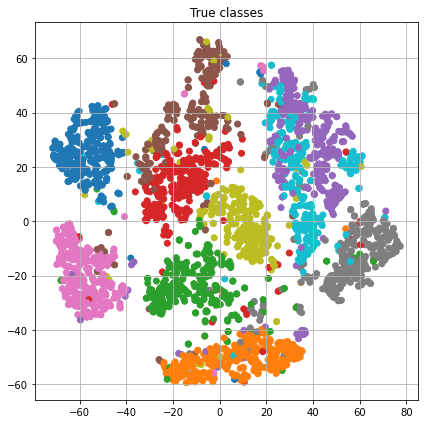

In [389]:
plt.figure(figsize=(6, 6))
plt.scatter(X_m_pca2_reduced[:, 0], X_m_pca2_reduced[:, 1], 
            c=y_m, cmap='tab10')
plt.grid()
plt.title("True classes")
save_fig("2dset_true")
plt.show()

Saving figure 2dset_blue


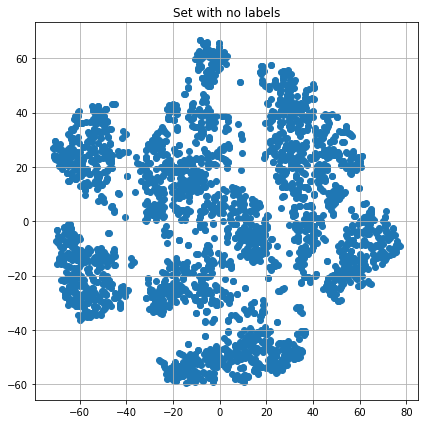

In [391]:
plt.figure(figsize=(6, 6))
plt.scatter(X_m_pca2_reduced[:, 0], X_m_pca2_reduced[:, 1])
plt.grid()
plt.title("Set with no labels")
save_fig("2dset_blue")
plt.show()

In [393]:
X_m_final, y_m_final = X_m_pca2_reduced, y_m

## Zbiór FIFA 22 

In [582]:
# fetch fifa22 dataset

fifa_df_to_process = pd.read_csv('players_22.csv', sep=',', dtype={"nation_position": 'string', 
                                                        "nation_logo_url": "string"})

In [148]:
fifa_df_to_process.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 110 entries, sofifa_id to nation_flag_url
dtypes: float64(16), int64(44), object(48), string(2)
memory usage: 16.1+ MB


In [149]:
lewy_stats = pd.concat([pd.melt(fifa_df_to_process.iloc[1:2, :]), 
                        pd.DataFrame(fifa_df_to_process.iloc[1:2, :].dtypes
                                    ).reset_index().loc[:, 0]], axis=1)

In [176]:
# lewy_stats.iloc[:60]

In [177]:
# lewy_stats[60:]

In [144]:
fifa_df_numeric = pd.concat([fifa_df_to_process.iloc[:, :78].select_dtypes(include=[np.number]), 
                             fifa_df_to_process.iloc[:, 78:105].applymap(
                                    lambda x: eval(x) if not pd.isna(x) else x)],
                            axis=1)

In [168]:
fifa_df_relevant = fifa_df_numeric.drop(columns=['sofifa_id',
                                                 'club_jersey_number',
                                                 'club_contract_valid_until',
                                                 'nation_jersey_number',
                                                 'nation_team_id',
                                                 'club_team_id',
                                                 'nationality_id',
                                                 'release_clause_eur',
                                                 'value_eur',
                                                 'wage_eur',
                                                 'goalkeeping_speed'])

In [178]:
# fifa_df_relevant.info()

In [171]:
fifa_df_relevant.shape

(19239, 76)

In [172]:
fifa_df_final = fifa_df_relevant.dropna()

In [173]:
fifa_df_final.shape

(17054, 76)

In [174]:
fifa_df_final.describe()

,overall,potential,age,height_cm,weight_kg,league_level,weak_foot,skill_moves,international_reputation,pace,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
count,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,...,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000,17054.000000
mean,65.930222,71.238947,25.078574,180.387768,74.090125,1.356515,3.001290,2.520699,1.095344,68.216958,...,59.272487,59.272487,59.272487,60.007154,59.305852,57.820511,57.820511,57.820511,59.305852,18.049197
std,6.773414,6.050498,4.627043,6.544959,6.695541,0.750159,0.649778,0.637488,0.372402,10.928697,...,9.959505,9.959505,9.959505,8.809380,9.401733,11.411536,11.411536,11.411536,9.401733,1.812337
min,47.000000,49.000000,16.000000,155.000000,49.000000,1.000000,1.000000,2.000000,1.000000,28.000000,...,29.000000,29.000000,29.000000,33.000000,31.000000,27.000000,27.000000,27.000000,31.000000,11.000000
25%,62.000000,67.000000,21.000000,176.000000,70.000000,1.000000,3.000000,2.000000,1.000000,62.000000,...,52.000000,52.000000,52.000000,54.000000,53.000000,49.000000,49.000000,49.000000,53.000000,17.000000
50%,66.000000,71.000000,25.000000,180.000000,74.000000,1.000000,3.000000,2.000000,1.000000,69.000000,...,60.000000,60.000000,60.000000,61.000000,60.000000,60.000000,60.000000,60.000000,60.000000,18.000000
75%,70.000000,75.000000,28.000000,185.000000,78.000000,1.000000,3.000000,3.000000,1.000000,76.000000,...,66.000000,66.000000,66.000000,66.000000,66.000000,67.000000,67.000000,67.000000,66.000000,19.000000
max,93.000000,95.000000,54.000000,203.000000,110.000000,5.000000,5.000000,5.000000,5.000000,97.000000,...,90.000000,90.000000,90.000000,88.000000,88.000000,89.000000,89.000000,89.000000,88.000000,40.000000


In [175]:
fifa_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17054 entries, 0 to 19238
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   overall                      17054 non-null  int64  
 1   potential                    17054 non-null  int64  
 2   age                          17054 non-null  int64  
 3   height_cm                    17054 non-null  int64  
 4   weight_kg                    17054 non-null  int64  
 5   league_level                 17054 non-null  float64
 6   weak_foot                    17054 non-null  int64  
 7   skill_moves                  17054 non-null  int64  
 8   international_reputation     17054 non-null  int64  
 9   pace                         17054 non-null  float64
 10  shooting                     17054 non-null  float64
 11  passing                      17054 non-null  float64
 12  dribbling                    17054 non-null  float64
 13  defending       

In [ ]:
# fifa_df_to_process.loc[fifa_df_final.index, :]

# Narzędzia diagnostyczne

Potrzebujemy również (względnie) obiektywnego sposobu oceny jak solidna jest uzyskana
klasteryzacja, lepszego niż tzw. technika "na oko" (liczby można porównywać, z subiektywnymi
wrażeniami jest nieco trudniej). Na szczęście jest to dość standardowa potrzeba i odpowiednie
narzędzia są powszechnie dostępne - przykładowo: lubiona przez nas biblioteka scikit-learn
oferuje szerokie spektrum sposobów na ewaluację otrzymanego grupowania (patrz: [link](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)).

Na poczet reszty zadania wybierzmy dwie dowolne miary jakości klasteryzacji. Nadają się
dowolne dwie - warto jednak przeczytać o nich choć trochę (wiedzieć czym się
charakteryzują, na co są wyczulone, co ignorują, etc.).

**(Adjusted) Rand Index**

If $C$ is a ground truth class assignment and $K$ the clustering, let us define $a$ and $b$ as:
- $a$, the number of pairs of elements that are in the same set in C and in the same set in K

- $b$, the number of pairs of elements that are in different sets in C and in different sets in K

$$
    RI = \frac{a+b}{C^{n_{samples}}_2}
$$
However, the Rand index does not guarantee that random label assignments will get a value close to zero (esp. if the number of clusters is in the same order of magnitude as the number of samples).
To counter this effect we can discount the expected $E[RI]$  of random labelings by defining the adjusted Rand index as follows:
$$
    ARI = \frac{RI - E[RI]}{max(RI) - E[RI]}
$$
*(scikit-learn docs)*

sklearn:
- `sklearn.metrics.rand_score(labels_true, labels_pred)`
- `sklearn.metrics.adjusted_rand_score(labels_true, labels_pred)`

        Rand Index nada się dla pierwszego zbioru (bo mamy labelki).
        Poniższe sposoby ewaluacji będą przydatne dla zbiotu FIFA 22.

---

**Calinski-Harabasz Index**

(zakłada wypukłość - tak jak k-means)

większy <=> lepsza klasteryzacja

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared):

*(scikit-learn docs)*

sklearn:
- `sklearn.metrics.calinski_harabasz_score(X, labels)`

---

**Davies-Bouldin Index**

(zakłada wypukłość - tak jak k-means)

mniejszy <=> lepsza klasteryzacja

This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.


sklearn:
- `sklearn.metrics.davies_bouldin_score(X, labels)`

In [395]:
# define metrics

from sklearn.metrics import rand_score, adjusted_rand_score, \
                            calinski_harabasz_score, davies_bouldin_score

def get_rand_index(labels_true, labels_pred) -> float:
    return rand_score(labels_true, labels_pred)

def get_adj_rand_index(labels_true, labels_pred) -> float:
    return adjusted_rand_score(labels_true, labels_pred)

def get_cal_har_index(X, labels) -> float:
    return calinski_harabasz_score(X, labels)

def get_dav_bou_index(X, labels) -> float:
    return davies_bouldin_score(X, labels)

In [396]:
from sklearn.cluster import KMeans

kmeans_default = KMeans(n_clusters=10, init='k-means++', random_state=311).fit(X_m_final)
default_labels_pred = kmeans_default.labels_

In [397]:
l_true_test = [0, 0, 0, 1, 1, 1]
l_pred_test = [0, 0, 1, 1, 2, 2]

print("Deafault KMeans with k=10 on 2d dataset: ")
print("Rand Index: ", get_rand_index(y_m_final, default_labels_pred))
print("Adjusted Rand Index: ", get_adj_rand_index(y_m_final, default_labels_pred))
print("Calinski Harabasz Index: ", get_cal_har_index(X_m_final, default_labels_pred))
print("Davies Bouldin Index: ", get_dav_bou_index(X_m_final, default_labels_pred))

Deafault KMeans with k=10 on 2d dataset: 
Rand Index:  0.9275516283205513
Adjusted Rand Index:  0.607031242851278
Calinski Harabasz Index:  4132.406812860546
Davies Bouldin Index:  0.6761933213452174


Saving figure 2dset_true_vs_kmeans


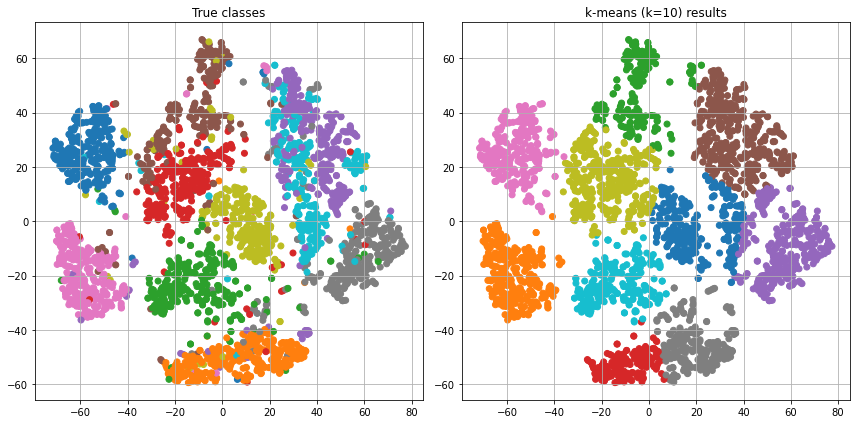

In [410]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(X_m_final[:, 0], X_m_final[:, 1], 
            c=y_m_final, cmap='tab10')
plt.grid()
plt.title("True classes")

plt.subplot(122)
plt.scatter(X_m_final[:, 0], X_m_final[:, 1], 
            c=default_labels_pred, cmap='tab10')
plt.grid()
plt.title("k-means (k=10) results")

save_fig("2dset_true_vs_kmeans")
plt.show()

# Ustalanie właściwego poziomu rozdrobnienia

Pora zabrać się za wspominane wcześniej dobieranie parametru $k$ (czyli liczby klastrów do
odnalezienia). Podejdziemy do tego na dwa sposoby.



## Pierwszy sposób

Prostszy z nich to technika znana powszechnie jako tzw. zasada łokcia (elbow rule).

- Przyjmijmy rozsądny zakres rozważanych k (np. od 1 do 30). Dla każdego k z tego zakresu:
    - kilkakrotnie wykonajmy klasteryzację metodą k-means (z inicjalizacją k-means++);
    - dla każdego uzyskanego grupowania obliczmy wybrane w poprzedniej sekcji miary jakości, wyciągnijmy z nich średnie, zanotujmy odchylenia standardowe.
- W efekcie powinniśmy uzyskać dwa wykresy przedstawiające zależność danej metryki
od parametru k. Dla zadania klasteryzacji typowy jest trend w którym początkowo
wartość metryki bardzo szybko ulega poprawie - ale od pewnego k stabilizuje się i
zmienia swą wartość znacznie wolniej. Tworzy to charakterystyczny kształt ugiętej ręki.
Miejsce, gdzie ręka miałaby łokieć zazwyczaj wyznacza potencjalnie-optymalną wartość
parametru.
- Sprawdźmy wartości k wyznaczone w ten sposób dla każdej z miar jakości.
    - Czy są takie same?
    - Czy są zgodne z oczekiwanym k?
    - Jak dla tych k wygląda podział punktów na klastry? Czy jest zgodny z tym oczekiwanym? Czy "ma sens"?

In [377]:
# impl 1st manner

from sklearn.cluster import KMeans

def get_metrics_k_elbow_rule(X: np.ndarray, n_repeated=10, k_range=(2, 30),
                             metric_func=get_dav_bou_index) -> Tuple[np.ndarray, np.ndarray]:
    res_size = k_range[1] - k_range[0]
    metric_means = np.empty(res_size)
    metric_stds = np.empty(res_size)
    for k in range(*k_range):
        metrics_repeated = []
        for _ in range(n_repeated):
            kmeans_model = KMeans(n_clusters=k, init='k-means++').fit(X)
            metrics_repeated.append(metric_func(X, kmeans_model.labels_))
        metric_means[k - k_range[0]] = np.array(metrics_repeated).mean()
        metric_stds[k - k_range[0]] = np.array(metrics_repeated).std(ddof=1)
    
    return metric_means, metric_stds

In [694]:
dav_bou_idx_means, dav_bou_idx_stds = get_metrics_k_elbow_rule(X_m_final, k_range=(2, 30),
                                                               metric_func=get_dav_bou_index)

In [695]:
cal_har_idx_means, cal_har_idx_stds = get_metrics_k_elbow_rule(X_m_final, k_range=(2, 30),
                                                               metric_func=get_cal_har_index)

Saving figure 2dset_1st_met


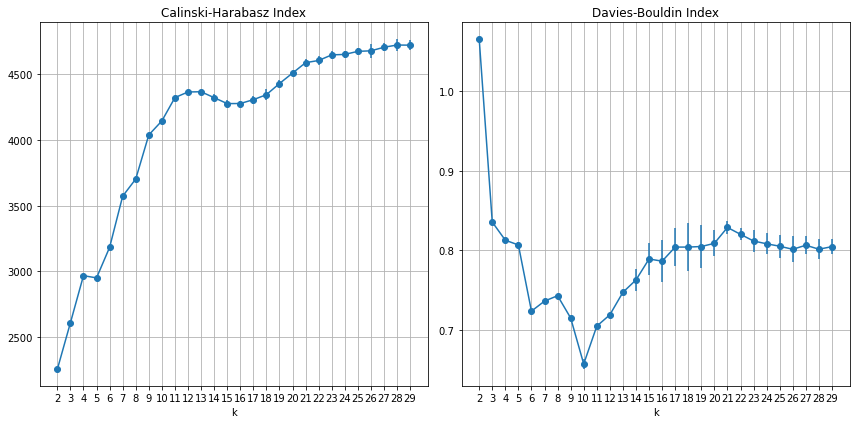

In [696]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.errorbar(np.arange(2, 30), cal_har_idx_means, yerr=cal_har_idx_stds, fmt='-o')
plt.grid()
plt.xticks(np.arange(2, 30))
plt.xlabel("k")
plt.title("Calinski-Harabasz Index")

plt.subplot(122)
plt.errorbar(np.arange(2, 30), dav_bou_idx_means, yerr=dav_bou_idx_stds, fmt='-o')
plt.grid()
plt.xticks(np.arange(2, 30))
plt.xlabel("k")
plt.title("Davies-Bouldin Index")

save_fig("2dset_1st_met")
plt.show()

In [411]:
from sklearn.cluster import KMeans

kmeans_6 = KMeans(n_clusters=6, init='k-means++', random_state=311).fit(X_m_final)
labels_pred_6 = kmeans_6.labels_

kmeans_10 = KMeans(n_clusters=10, init='k-means++', random_state=311).fit(X_m_final)
labels_pred_10 = kmeans_10.labels_

kmeans_12 = KMeans(n_clusters=12, init='k-means++', random_state=311).fit(X_m_final)
labels_pred_12 = kmeans_12.labels_

Saving figure 2dset_true_vs_kmeans_k_6_10_12


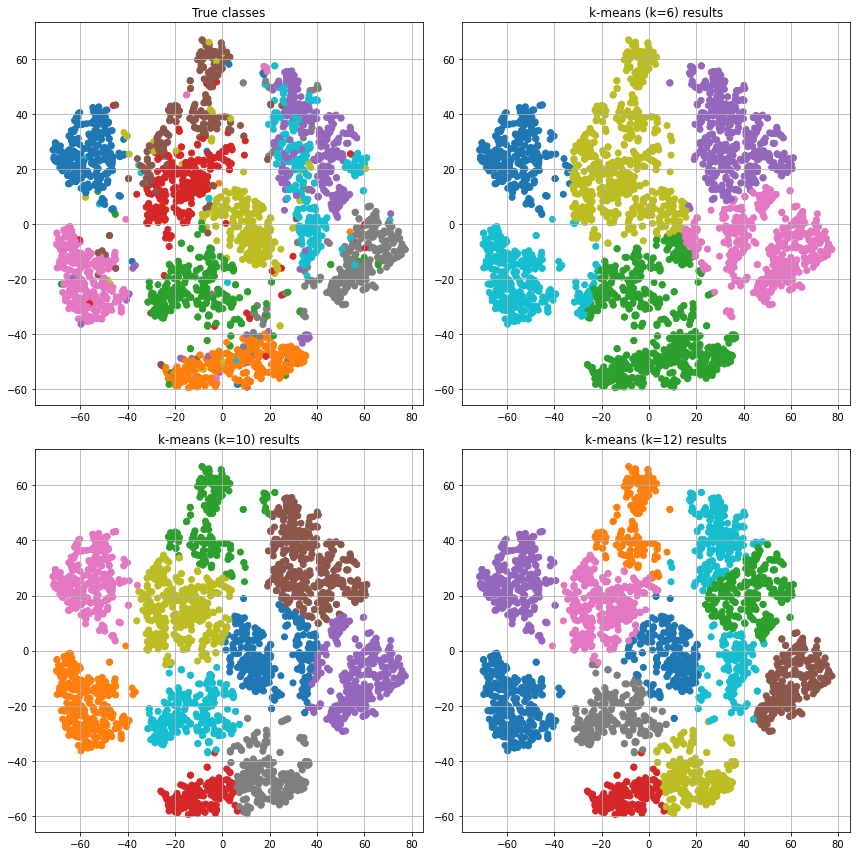

In [413]:
plt.figure(figsize=(12, 12))

plt.subplot(221)
plt.scatter(X_m_final[:, 0], X_m_final[:, 1], 
            c=y_m_final, cmap='tab10')
plt.grid()
plt.title("True classes")

plt.subplot(222)
plt.scatter(X_m_final[:, 0], X_m_final[:, 1], 
            c=labels_pred_6, cmap='tab10')
plt.grid()
plt.title("k-means (k=6) results")

plt.subplot(223)
plt.scatter(X_m_final[:, 0], X_m_final[:, 1], 
            c=labels_pred_10, cmap='tab10')
plt.grid()
plt.title("k-means (k=10) results")

plt.subplot(224)
plt.scatter(X_m_final[:, 0], X_m_final[:, 1], 
            c=labels_pred_12, cmap='tab10')
plt.grid()
plt.title("k-means (k=12) results")

save_fig("2dset_true_vs_kmeans_k_6_10_12")
plt.show()

In [436]:
pd.Series(y_m_final).value_counts()

1    339
7    329
4    325
6    306
2    299
3    295
9    287
0    285
5    274
8    261
dtype: int64

In [437]:
pd.Series(labels_pred_10).value_counts()

5    425
8    379
4    353
1    316
0    308
6    295
9    263
7    256
2    230
3    175
dtype: int64

In [415]:
get_rand_index(y_m_final, labels_pred_10)

0.9275516283205513

In [416]:
get_adj_rand_index(y_m_final, labels_pred_10)

0.607031242851278

## Drugi sposób

Druga technika jest nieco trudniejsza i zakłada adaptatywne hierarchiczne dobieranie liczby klastrów.

Wykorzystujemy tu następujący algorytm:
- Początkowo wszystkie punkty należą do jednego klastra.
- Dla klastra tego wykonujemy klasteryzację k-means z k=2.
- Uzyskamy w ten sposób dwa nowe centra klastrów. Wyznaczają one pewną prostą przecinającą całą przestrzeń obserwacji.
- Rzutujemy wszystkie obserwacje z naszego klastra na tą prostą - teraz będą je reprezentowały pojedyncze liczby.
- Sprawdzamy, czy efekt takiego rzutowania pasuje do rozkładu normalnego (jego histogram tworzy jedną górkę o charakterystycznym "gaussowatym" kształcie).
    - Jak to zrobić? Tutorial z fragmentami kodu do skopiowania dostępny tutaj (sekcja *Statistical Normality Tests*): [link](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/). Niezależnie od wybranego testu, będzie trzeba ustalić poziom czułości (dobrać odpowiednią wartość progową dla *p-value*).
- Wynikiem testu jest jeden z dwóch scenariuszy.
    - Tak! Punkty po zrzutowaniu na prostą tworzą rozkład normalny. To znaczy, że nasz oryginalny klaster jest zupełnie w porządku i nie należy go rozdrabniać na dwa mniejsze. Zostawiamy go takim, jakim był.
    - Nie! Punkty po zrzutowaniu na prostą nie pasują do rozkładu normalnego. To znaczy, że początkowy klaster wymaga rozbicia na mniejsze podgrupki.
        - Dzielimy klaster na dwa podklastry znalezione przed chwilą przez kmeans.
        - Dla każdego z podklastrów rekurencyjnie uruchamiamy tę samą procedurę (podział na dwa mniejsze klastry, wyznaczenie prostej, rzutowanie, test na normalność, decyzja o dalszych podziałach).
- Algorytm kończymy, gdy nie są już konieczne dalsze podziały (każdy ze znalezionych klastrów zdał test na normalność).
    - Alternatywnie - nie rozdrabniamy dalej klastrów, które mają mniej członków niż ustalona minimalna wartość (jeżeli grupa zawiera np. 5 elementów, to raczej nie warto jej dalej dzielić).

Pobawmy się chwilę algorytmem, eksperymentując z różnymi programi czułości.
- Jakie podziały znajdujemy?
- Czy są lepsze od tych "łokciowych" (pod względem metryk, jak i "na oko")?
- Czy metoda znalazła oczekiwaną liczbę klastrów?

In [520]:
def points_on_line(c1: np.ndarray, c2: np.ndarray, P: np.ndarray):
    """
    Projets point(s) on line defined by c1 and c2
    
    :param p: point or points to be projected
    :type p: 1 or 2 dimentional np.ndarray
    :return: projected point(s)
    """
    assert c1.ndim == 1 and c2.ndim == 1, "c1 and c2 need to be 1d numpy arrays"
    assert P.ndim in (1, 2), "P needs to be a 1d/2d numpy array"
    c1_P = P - c1
    c1_c2 = c2 - c1
    return np.squeeze(c1 + ((c1_c2 @ c1_P.T).reshape(-1, 1) * c1_c2) / np.dot(c1_c2, c1_c2))

In [522]:
# generate univariate observations
data = 5 * np.random.randn(100) + 50
print('mean=%.3f stdv=%.3f' % (np.mean(data), np.std(data)))

mean=49.700 stdv=4.447


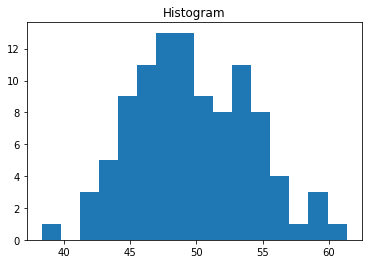

In [532]:
plt.hist(data, bins=16)
plt.title("Histogram")
plt.show()

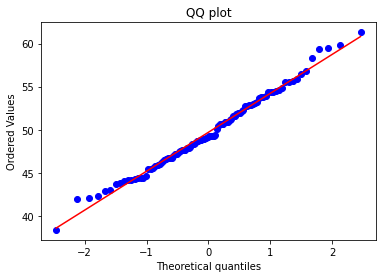

In [531]:
from scipy.stats import probplot

probplot(data, dist="norm", plot=plt)
plt.title("QQ plot")
plt.show()

In [533]:
from scipy.stats import shapiro

stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.990, p=0.643
Sample looks Gaussian (fail to reject H0)


In [551]:
from scipy.stats import shapiro

def check_if_normal_dist(points: np.ndarray, p_value_threshold: float):
    assert points.ndim in (1, 2), "points need to be a 1d/2d numpy array"
    if points.ndim == 1:
        return True
    
    _, p_value = shapiro(points)
    # print(f"p_value = {p_value}")
    if p_value >= p_value_threshold:
        return True
    else:
        return False

In [546]:
# impl 2nd manner

from sklearn.cluster import KMeans

def find_k_h_recursive(X: np.ndarray, p_value_threshold=0.05, max_depth=6):
    
    def split_clusters(X_i: np.ndarray, depth=0):
        nonlocal X, p_value_threshold, max_depth
        
        if depth >= max_depth or len(X_i) == 1:
            return [X_i], 1
        
        X_curr = X[X_i]
        
        # kmeans with k=2
        kmeans_model = KMeans(n_clusters=2, init='k-means++').fit(X_curr)
        labels = kmeans_model.labels_  # consists of 0s and 1s
        
        X_i_A = X_i[labels==0]
        X_i_B = X_i[labels==1]
        
        # note that 1/2 in c_* is not consistent with A/B in X_i_*
        c_1 = kmeans_model.cluster_centers_[0]
        c_2 = kmeans_model.cluster_centers_[1]
        
        # project points onto c1-c2 line
        points = point_on_line(c_1, c_2, X_curr)
        
        # check normality of points on the line
        normal_enough = check_if_normal_dist(points, p_value_threshold)
        
        if normal_enough:
            return [X_i], 1
        else:
            X_i_listA, k_resA = split_clusters(X_i_A, depth=depth+1)
            X_i_listB, k_resB = split_clusters(X_i_B, depth=depth+1)
            return X_i_listA + X_i_listB, k_resA + k_resB
        
    list_of_clusters, k = split_clusters(np.arange(X.shape[0]))
    res_labels = np.empty(X.shape[0], dtype=np.int32)
    for label, cluster_i in enumerate(list_of_clusters):
        res_labels[cluster_i] = label
    
    return res_labels, k

In [656]:
set2d_hrec_labels, k_set2d_hrec = find_k_h_recursive(X_m_final, 
                                                     p_value_threshold=1e-9, 
                                                     max_depth=8)

C:\Users\User\anaconda3\envs\tf2\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [657]:
print(f"k = {k_set2d_hrec}")

k = 107


In [662]:
from sklearn.cluster import KMeans

kmeans_107 = KMeans(n_clusters=107, init='k-means++', random_state=311).fit(X_m_final)
labels_pred_107 = kmeans_107.labels_

Saving figure 2dset_kmeans_k107_h_rec


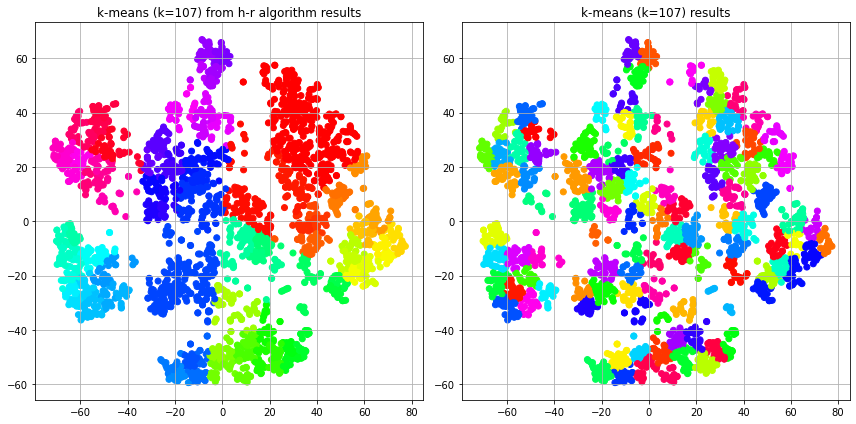

In [691]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(X_m_final[:, 0], X_m_final[:, 1], 
            c=set2d_hrec_labels, cmap='hsv')
plt.grid()
plt.title("k-means (k=107) from h-r algorithm results")

plt.subplot(122)
plt.scatter(X_m_final[:, 0], X_m_final[:, 1], 
            c=labels_pred_107, cmap='hsv')
plt.grid()
plt.title("k-means (k=107) results")
save_fig("2dset_kmeans_k107_h_rec")
plt.show()


# Zderzenie z rzeczywistością

Przetestujmy oba podejścia ("łokciowe" i "hierarchiczno-rekurencyjne") na bardziej rzeczywistych danych. W załączniku znajduje się plik CSV zawierający informacje o charakterystykach wirtualnych piłkarzy (opartych o dane znajdujące się na tej witrynie https://sofifa.com/player/158023/lionel-messi/).

Naszym celem jest poklastrowanie zawodników na grupy o podobnej charakterystyce. W tym
celu wykonujemy następujące kroki.
- Sprzątamy zbiór danych. Usuwamy z niego te kolumny, które nie pasują do problemu (albo zawierają już informacje o arbitralnym pogrupowaniu). Skupiamy się na tych cechach, które mają wartości liczbowe. Część z nich wymaga ponownego przeliczenia (bo jest np. w formacie 90+2).
- Oczyszczony zbiór dzielimy na grupy z użyciem obu przygotowanych wcześniej metod.
    - Na ile klastrów został podzielony?
    - Jakich zawodników zawierają te klastry (ustalamy to na podstawie położenia centrów i/lub nazwisk leżących w centrum klastra zawodników)?
    - Czy podział wydaje się mieć sens?

In [556]:
fifa_df_with_idx = fifa_df_final.reset_index()

In [575]:
fifa_df_idx = fifa_df_with_idx["index"]

In [558]:
fifa_df_with_idx.head()

,index,overall,potential,age,height_cm,weight_kg,league_level,weak_foot,skill_moves,international_reputation,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,0,93,93,34,170,72,1.0,4,4,5,...,67,67,67,69,64,53,53,53,64,22
1,1,92,92,32,185,81,1.0,4,4,5,...,69,69,69,67,64,63,63,63,64,22
2,2,91,91,36,187,83,1.0,4,5,5,...,62,62,62,66,63,56,56,56,63,23
3,3,91,91,29,175,68,1.0,5,5,5,...,66,66,66,70,65,53,53,53,65,23
4,4,91,91,30,181,70,1.0,5,4,4,...,83,83,83,82,78,72,72,72,78,24


In [560]:
fifa_df = fifa_df_with_idx.drop(columns=["index"])

In [562]:
X_fifa = fifa_df.to_numpy()

## Podejście "łokciowe"

In [567]:
dav_bou_idx_means, dav_bou_idx_stds = get_metrics_k_elbow_rule(X_fifa,
                                                               k_range=(2, 30),
                                                               metric_func=get_dav_bou_index,
                                                               n_repeated=5)

In [568]:
cal_har_idx_means, cal_har_idx_stds = get_metrics_k_elbow_rule(X_fifa,
                                                               k_range=(2, 30),
                                                               metric_func=get_cal_har_index,
                                                               n_repeated=5)

Saving figure fifa_1st_met


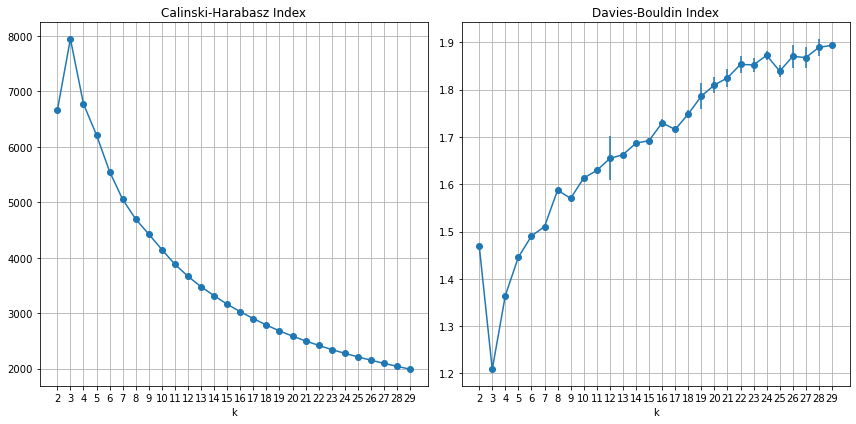

In [692]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.errorbar(np.arange(2, 30), cal_har_idx_means, yerr=cal_har_idx_stds, fmt='-o')
plt.grid()
plt.xticks(np.arange(2, 30))
plt.xlabel("k")
plt.title("Calinski-Harabasz Index")

plt.subplot(122)
plt.errorbar(np.arange(2, 30), dav_bou_idx_means, yerr=dav_bou_idx_stds, fmt='-o')
plt.grid()
plt.xticks(np.arange(2, 30))
plt.xlabel("k")
plt.title("Davies-Bouldin Index")

save_fig("fifa_1st_met")
plt.show()

In [571]:
from sklearn.cluster import KMeans

kmeans_fifa_3 = KMeans(n_clusters=3, init='k-means++', random_state=311).fit(X_fifa)
labels_pred_fifa_3 = kmeans_6.labels_

kmeans_fifa_8 = KMeans(n_clusters=8, init='k-means++', random_state=311).fit(X_fifa)
labels_pred_fifa_8 = kmeans_12.labels_

In [601]:
fifa_df_peek = fifa_df_to_process.drop(columns=["player_url", "short_name", "player_face_url",
                                                "club_logo_url", "club_flag_url", 
                                                "nation_logo_url", "nation_flag_url"])

k = 3

In [602]:
fifa_df_peek.iloc[fifa_df_idx[labels_pred_fifa_3==0]].head(10)

,sofifa_id,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
64,213345,Kingsley Junior Coman,"LM, RM, LW",86,87,81000000.0,120000.0,25,1996-06-13,180,...,55+3,55+3,55+3,60+3,56+3,45+3,45+3,45+3,56+3,13+3
126,212188,Timo Werner,"ST, LW",84,87,56500000.0,155000.0,25,1996-03-06,180,...,57+3,57+3,57+3,61+3,58+3,50+3,50+3,50+3,58+3,19+3
141,169416,Carlos Alberto Vela Garrido,"RW, LW, CAM",83,83,29000000.0,17000.0,32,1989-03-01,177,...,57+3,57+3,57+3,59+3,54+3,47+3,47+3,47+3,54+3,19+3
163,201153,Álvaro Borja Morata Martín,ST,83,83,37000000.0,84000.0,28,1992-10-23,190,...,55+3,55+3,55+3,58+3,54+3,50+3,50+3,50+3,54+3,13+3
164,201399,Mauro Emanuel Icardi Rivero,ST,83,83,37000000.0,120000.0,28,1993-02-19,181,...,54+3,54+3,54+3,53+3,51+3,50+3,50+3,50+3,51+3,17+3
178,215333,Duván Esteban Zapata Banguera,ST,83,83,35500000.0,77000.0,30,1991-04-01,189,...,54+2,54+2,54+2,54+2,52+2,53+2,53+2,53+2,52+2,16+2
179,216354,Andrej Kramarić,"ST, CAM",83,83,35500000.0,59000.0,30,1991-06-19,177,...,56+3,56+3,56+3,58+3,54+3,48+3,48+3,48+3,54+3,19+3
225,199110,Luis Fernando Muriel Fruto,ST,82,82,30000000.0,70000.0,30,1991-04-16,179,...,52+2,52+2,52+2,58+2,53+2,45+2,45+2,45+2,53+2,18+2
230,202651,Jesús Joaquín Fernández Sáez de la Torre,RW,82,82,32500000.0,42000.0,27,1993-11-19,176,...,56+2,56+2,56+2,60+2,54+2,43+2,43+2,43+2,54+2,19+2
263,229906,Leon Bailey Butler,"RM, RW, LW",82,85,41500000.0,75000.0,23,1997-08-09,178,...,54+3,54+3,54+3,59+3,55+3,46+3,46+3,46+3,55+3,20+3


In [603]:
fifa_df_peek.iloc[fifa_df_idx[labels_pred_fifa_3==1]].head(10)

,sofifa_id,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
56,201024,Kalidou Koulibaly,CB,86,86,55500000.0,105000.0,30,1991-06-20,187,...,76+3,76+3,76+3,73+3,76+3,85+1,85+1,85+1,76+3,17+3
115,204639,Stefan Savić,CB,84,84,34500000.0,74000.0,30,1991-01-08,187,...,78+2,78+2,78+2,70+2,74+2,84,84,84,74+2,21+2
120,207863,Felipe Augusto de Almeida Monteiro,CB,84,84,27500000.0,74000.0,32,1989-05-16,190,...,77+3,77+3,77+3,72+3,74+3,84,84,84,74+3,17+3
130,216460,José María Giménez de Vargas,CB,84,88,52000000.0,74000.0,26,1995-01-20,185,...,76+2,76+2,76+2,72+2,75+2,84+2,84+2,84+2,75+2,18+2
155,192774,Konstantinos Manolas,CB,83,83,30000000.0,80000.0,30,1991-06-14,189,...,74+3,74+3,74+3,71+3,75+3,83,83,83,75+3,18+3
244,212190,Niklas Süle,"CB, RB",82,87,40500000.0,78000.0,25,1995-09-03,195,...,76+3,76+3,76+3,69+3,73+3,81+3,81+3,81+3,73+3,19+3
325,204638,Vilmos Tamás Orban,CB,81,82,24500000.0,79000.0,28,1992-11-03,186,...,73+2,73+2,73+2,67+2,70+2,81+1,81+1,81+1,70+2,18+2
392,169588,Jonathan Grant Evans,CB,80,80,10000000.0,95000.0,33,1988-01-03,188,...,76+2,76+2,76+2,71+2,73+2,80,80,80,73+2,21+2
399,177509,Medhi Amine El Mouttaqi Benatia,CB,80,80,7000000.0,19000.0,34,1987-04-17,189,...,73+3,73+3,73+3,69+3,71+3,79+1,79+1,79+1,71+3,15+3
404,183855,Angelo Obinze Ogbonna,CB,80,80,10000000.0,70000.0,33,1988-05-23,191,...,74+2,74+2,74+2,70+2,72+2,80,80,80,72+2,12+2


In [604]:
fifa_df_peek.iloc[fifa_df_idx[labels_pred_fifa_3==2]].head(10)

,sofifa_id,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,158023,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,170,...,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3
1,188545,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,1988-08-21,185,...,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3
2,20801,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,187,...,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3
3,190871,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.0,270000.0,29,1992-02-05,175,...,63+3,63+3,63+3,67+3,62+3,50+3,50+3,50+3,62+3,20+3
4,192985,Kevin De Bruyne,"CM, CAM",91,91,125500000.0,350000.0,30,1991-06-28,181,...,80+3,80+3,80+3,79+3,75+3,69+3,69+3,69+3,75+3,21+3
6,231747,Kylian Mbappé Lottin,"ST, LW",91,95,194000000.0,230000.0,22,1998-12-20,182,...,63+3,63+3,63+3,67+3,63+3,54+3,54+3,54+3,63+3,18+3
9,202126,Harry Kane,ST,90,90,129500000.0,240000.0,27,1993-07-28,188,...,68+3,68+3,68+3,67+3,64+3,61+3,61+3,61+3,64+3,20+3
10,215914,N'Golo Kanté,"CDM, CM",90,90,100000000.0,230000.0,30,1991-03-29,168,...,87+3,87+3,87+3,85+3,85+3,84+3,84+3,84+3,85+3,20+3
11,165153,Karim Benzema,"CF, ST",89,89,66000000.0,350000.0,33,1987-12-19,185,...,62+3,62+3,62+3,63+3,59+3,55+3,55+3,55+3,59+3,18+3
13,200104,손흥민 孙兴慜,"LM, CF, LW",89,89,104000000.0,220000.0,28,1992-07-08,183,...,64+3,64+3,64+3,68+3,64+3,54+3,54+3,54+3,64+3,19+3


k = 8

In [687]:
fifa_df_peek.iloc[fifa_df_idx[labels_pred_fifa_8==3]].head(6)

,sofifa_id,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
4,192985,Kevin De Bruyne,"CM, CAM",91,91,125500000.0,350000.0,30,1991-06-28,181,...,80+3,80+3,80+3,79+3,75+3,69+3,69+3,69+3,75+3,21+3
9,202126,Harry Kane,ST,90,90,129500000.0,240000.0,27,1993-07-28,188,...,68+3,68+3,68+3,67+3,64+3,61+3,61+3,61+3,64+3,20+3
10,215914,N'Golo Kanté,"CDM, CM",90,90,100000000.0,230000.0,30,1991-03-29,168,...,87+3,87+3,87+3,85+3,85+3,84+3,84+3,84+3,85+3,20+3
14,200145,Carlos Henrique Venancio Casimiro,CDM,89,89,88000000.0,310000.0,29,1992-02-23,185,...,86+3,86+3,86+3,80+3,81+3,86+3,86+3,86+3,81+3,21+3
15,203376,Virgil van Dijk,CB,89,89,86000000.0,230000.0,29,1991-07-08,193,...,84+3,84+3,84+3,79+3,81+3,88+1,88+1,88+1,81+3,20+3
17,209331,Mohamed Salah Ghaly,RW,89,89,101000000.0,270000.0,29,1992-06-15,175,...,68+3,68+3,68+3,71+3,67+3,58+3,58+3,58+3,67+3,22+3


In [688]:
fifa_df_peek.iloc[fifa_df_idx[labels_pred_fifa_8==6]].head(6)

,sofifa_id,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,158023,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,170,...,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3
1,188545,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,1988-08-21,185,...,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3
2,20801,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,187,...,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3
3,190871,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.0,270000.0,29,1992-02-05,175,...,63+3,63+3,63+3,67+3,62+3,50+3,50+3,50+3,62+3,20+3
6,231747,Kylian Mbappé Lottin,"ST, LW",91,95,194000000.0,230000.0,22,1998-12-20,182,...,63+3,63+3,63+3,67+3,63+3,54+3,54+3,54+3,63+3,18+3
11,165153,Karim Benzema,"CF, ST",89,89,66000000.0,350000.0,33,1987-12-19,185,...,62+3,62+3,62+3,63+3,59+3,55+3,55+3,55+3,59+3,18+3


## Podejście "hierarchiczno-rekurencyjne"

In [674]:
labels_pred_fifa_h_rec, k_fifa_h_rec = find_k_h_recursive(X_fifa, 
                                                          p_value_threshold=1e18, 
                                                          max_depth=6)

C:\Users\User\anaconda3\envs\tf2\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\User\anaconda3\envs\tf2\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\User\anaconda3\envs\tf2\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\User\anaconda3\envs\tf2\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\User\anaconda3\envs\tf2\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\U

C:\Users\User\anaconda3\envs\tf2\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\User\anaconda3\envs\tf2\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\User\anaconda3\envs\tf2\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\User\anaconda3\envs\tf2\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\User\anaconda3\envs\tf2\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\U

In [676]:
print(f"k = {k_fifa_h_rec}")

k = 64


In [677]:
from sklearn.cluster import KMeans

kmeans_fifa_64 = KMeans(n_clusters=64, init='k-means++', random_state=311).fit(X_fifa)
labels_pred_fifa_64 = kmeans_6.labels_

In [678]:
fifa_df_peek.iloc[fifa_df_idx[labels_pred_fifa_64==0]].head(10)

,sofifa_id,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
64,213345,Kingsley Junior Coman,"LM, RM, LW",86,87,81000000.0,120000.0,25,1996-06-13,180,...,55+3,55+3,55+3,60+3,56+3,45+3,45+3,45+3,56+3,13+3
126,212188,Timo Werner,"ST, LW",84,87,56500000.0,155000.0,25,1996-03-06,180,...,57+3,57+3,57+3,61+3,58+3,50+3,50+3,50+3,58+3,19+3
141,169416,Carlos Alberto Vela Garrido,"RW, LW, CAM",83,83,29000000.0,17000.0,32,1989-03-01,177,...,57+3,57+3,57+3,59+3,54+3,47+3,47+3,47+3,54+3,19+3
163,201153,Álvaro Borja Morata Martín,ST,83,83,37000000.0,84000.0,28,1992-10-23,190,...,55+3,55+3,55+3,58+3,54+3,50+3,50+3,50+3,54+3,13+3
164,201399,Mauro Emanuel Icardi Rivero,ST,83,83,37000000.0,120000.0,28,1993-02-19,181,...,54+3,54+3,54+3,53+3,51+3,50+3,50+3,50+3,51+3,17+3
178,215333,Duván Esteban Zapata Banguera,ST,83,83,35500000.0,77000.0,30,1991-04-01,189,...,54+2,54+2,54+2,54+2,52+2,53+2,53+2,53+2,52+2,16+2
179,216354,Andrej Kramarić,"ST, CAM",83,83,35500000.0,59000.0,30,1991-06-19,177,...,56+3,56+3,56+3,58+3,54+3,48+3,48+3,48+3,54+3,19+3
225,199110,Luis Fernando Muriel Fruto,ST,82,82,30000000.0,70000.0,30,1991-04-16,179,...,52+2,52+2,52+2,58+2,53+2,45+2,45+2,45+2,53+2,18+2
230,202651,Jesús Joaquín Fernández Sáez de la Torre,RW,82,82,32500000.0,42000.0,27,1993-11-19,176,...,56+2,56+2,56+2,60+2,54+2,43+2,43+2,43+2,54+2,19+2
263,229906,Leon Bailey Butler,"RM, RW, LW",82,85,41500000.0,75000.0,23,1997-08-09,178,...,54+3,54+3,54+3,59+3,55+3,46+3,46+3,46+3,55+3,20+3


In [681]:
fifa_df_peek.iloc[fifa_df_idx[labels_pred_fifa_64==2]].head(10)

,sofifa_id,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,158023,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,170,...,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3
1,188545,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,1988-08-21,185,...,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3
2,20801,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,187,...,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3
3,190871,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.0,270000.0,29,1992-02-05,175,...,63+3,63+3,63+3,67+3,62+3,50+3,50+3,50+3,62+3,20+3
4,192985,Kevin De Bruyne,"CM, CAM",91,91,125500000.0,350000.0,30,1991-06-28,181,...,80+3,80+3,80+3,79+3,75+3,69+3,69+3,69+3,75+3,21+3
6,231747,Kylian Mbappé Lottin,"ST, LW",91,95,194000000.0,230000.0,22,1998-12-20,182,...,63+3,63+3,63+3,67+3,63+3,54+3,54+3,54+3,63+3,18+3
9,202126,Harry Kane,ST,90,90,129500000.0,240000.0,27,1993-07-28,188,...,68+3,68+3,68+3,67+3,64+3,61+3,61+3,61+3,64+3,20+3
10,215914,N'Golo Kanté,"CDM, CM",90,90,100000000.0,230000.0,30,1991-03-29,168,...,87+3,87+3,87+3,85+3,85+3,84+3,84+3,84+3,85+3,20+3
11,165153,Karim Benzema,"CF, ST",89,89,66000000.0,350000.0,33,1987-12-19,185,...,62+3,62+3,62+3,63+3,59+3,55+3,55+3,55+3,59+3,18+3
13,200104,손흥민 孙兴慜,"LM, CF, LW",89,89,104000000.0,220000.0,28,1992-07-08,183,...,64+3,64+3,64+3,68+3,64+3,54+3,54+3,54+3,64+3,19+3
